## Titanic 데이터를 가지고 FE 방법들 직접 사용해보기

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

데이터 불러오기

In [3]:
titanic_data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/YBIGTA/교육세션 6일차/titanic.csv")
display(titanic_data.head())

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


### <font color='blue'> 0. Null info check

In [4]:
# show overall information of titanic_data
titanic_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [5]:
# 각 feature 별 null값 정보 확인
titanic_data.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [6]:
# titanic_data의 shape을 확인하고, Age변수와 Cabin 변수의 null값 비율을 확인해보기
print(titanic_data.shape)
print(
    f"""Age의 null percentage : {(titanic_data.Age.isnull().sum())/titanic_data.shape[0]*100:.2f}%
    Fare의 null percentage : {(titanic_data.Fare.isnull().sum())/titanic_data.shape[0]*100:.2f}%
    Cabin의 null percentage : {(titanic_data.Cabin.isnull().sum())/titanic_data.shape[0]*100:.2f}%"""
)

(418, 11)
Age의 null percentage : 20.57%
    Fare의 null percentage : 0.24%
    Cabin의 null percentage : 78.23%


<font color='coral'> Cabin 변수의 경우 78% 이상의 높은 결측치 비율을 보여주고 있다.

In [7]:
print(
f"""
{titanic_data.Age.nunique()}
{titanic_data.Cabin.nunique()}
{titanic_data.Fare.nunique()}
""")


79
76
169



In [8]:
# 5가지 방법으로 FE를 진행하기 위해 titanic_data deepcopy로 복사
import copy
train1 = copy.deepcopy(titanic_data)

### <font color = "blue"> 1. Data Imputation

<font color = "gray">- Age 변수 : non-null값들의 Mean으로 Imputation

<font color = "gray">- Fare 변수 : non-null값들의 Mode값으로 대체; unique값이 너무 많음

<font color = "gray">- Cabin 변수 : 결측치 비율이 높으므로 Column 정보를 Drop

In [9]:
# Data Imputation & Drop
# train1로 진행
# Age의 경우 평균값으로 대체
train1.Age.fillna(train1.Age.mean(), inplace=True)
# Fare는 unique값이 많아 중앙값으로 대체
train1.Fare.fillna(train1.Fare.mode(), inplace=True)
# Cabin의 경우 Null값이 많아 Column을 drop
train11 = train1.drop(['Cabin'], axis=1)
print("Imputation 전 shape : ", titanic_data.shape)
print("Imputation 후 shape : ", train1.shape)
print("Drop Colum 후 shape : ", train11.shape)

Imputation 전 shape :  (418, 11)
Imputation 후 shape :  (418, 11)
Drop Colum 후 shape :  (418, 10)


In [10]:
display(train11.head())

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,S


In [11]:
train11.isnull().sum()

PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           1
Embarked       0
dtype: int64

### <font color = "blue"> 2. Indicator Variables 생성

<font color = "gray">- 이전에 Cabin Feature가 있는 Column을 모두 drop했으나 실제로 drop하는 것은 좋지 않은 선택일 수 있으므로 다시 train1을 기준으로 Cabin에 해당하는 지표변수를 만들어 대체해보았다.

In [12]:
# cabin의 경우만 결측치가 존재하던 상태
train1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          418 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [13]:
train2 = copy.deepcopy(train1)

In [14]:
# Cabin의 NaN값을 0으로 대체하기
train2.Cabin.fillna(0, inplace=True)
train2.isnull().sum()

PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           1
Cabin          0
Embarked       0
dtype: int64

In [15]:
# Cabin의 값이 Null인지 아닌지 여부를 판단하는 Indicator 변수를 만들기
def is_null(data):
  if data == 0:
    return 0
  else:
    return 1

train2["CabinNullIndicator"] = train2.Cabin.apply(is_null)
print(train2.CabinNullIndicator.nunique()) # 0과 1로 Cabin 변수의 Null 여부를 나타내는 Indicator 만들어짐.

2


In [16]:
train2.head(10)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,CabinNullIndicator
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,0,Q,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,0,S,0
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,0,Q,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,0,S,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,0,S,0
5,897,3,"Svensson, Mr. Johan Cervin",male,14.0,0,0,7538,9.2250,0,S,0
6,898,3,"Connolly, Miss. Kate",female,30.0,0,0,330972,7.6292,0,Q,0
7,899,2,"Caldwell, Mr. Albert Francis",male,26.0,1,1,248738,29.0000,0,S,0
8,900,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",female,18.0,0,0,2657,7.2292,0,C,0
9,901,3,"Davies, Mr. John Samuel",male,21.0,2,0,A/4 48871,24.1500,0,S,0


### <font color = "blue"> 3. 구간화 (Bining)

<font color = "gray">- 앞서 등장하는 Age의 경우는 연령대 별로 데이터를 구간화해볼 수 있다.

<font color = "green"> 구간화의 방법에는 여러 가지가 있다.
[참고자료](https://towardsdatascience.com/feature-engineering-examples-binning-numerical-features-7627149093d)

<font color = "brown"> 1. np.where()을 사용해 threshold Column을 만들고, apply()를 이용해 함수로 Bining하는 방법

<font color = "brown"> 2. `cut_label`과 `cut_bins`를 설정하고

<font color = "brown">pd.cut(df['new_column'], bins=cut_bins , labels=cut_label)을 활용하는 방법

<font color = "gray">이 떄 cut_bins를 np.arange(0, 80, 10) 등으로 표현하여 각 연령층 대 별로의 데이터를 나타내는 Indicator로 활용을 해볼 수도 있다.

In [17]:
train3 = copy.deepcopy(train2)

In [18]:
# Age변수의 최대, 최소 확인
display(train3.describe())
display(titanic_data.describe())

,PassengerId,Pclass,Age,SibSp,Parch,Fare,CabinNullIndicator
count,418.000000,418.000000,418.000000,418.000000,418.000000,417.000000,418.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188,0.217703
std,120.810458,0.841838,12.634534,0.896760,0.981429,55.907576,0.413179
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,23.000000,0.000000,0.000000,7.895800,0.000000
50%,1100.500000,3.000000,30.272590,0.000000,0.000000,14.454200,0.000000
75%,1204.750000,3.000000,35.750000,1.000000,0.000000,31.500000,0.000000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200,1.000000


,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


#### 1 . Threshold로 Indicator를 만들고 이로부터 지칭 값을 apply로 적용

- <font color = "blue"> np.where()로 threshold가 되는 Column을 생성하고, Indicator에 따라 값을 반환하는 함수를 apply하는 방식
- <font color = "blue"> 위의 describe로 나타난 결과의 4분위수가 되는 Age값을 참고하여 연령대를 분할해보았다.


In [19]:
train3['minors'] = np.where(train3['Age']<21, 1, 0) 
train3['seniors'] = np.where(train3['Age']>=39, 1, 0)

위 과정을 통해 Age 변수의 distribution을 두 개의 threshold인 21세와 39세 기준으로 split할 수 있는 Indicator 변수를 생성하였다.

In [20]:
def bind_age_groups(age):
  if age < 21:
    return "minor"
  elif age < 39:
    return "middle_aged"
  else:
    return "senior"

train3['generation'] = train3['Age'].apply(bind_age_groups)

In [21]:
train3.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,CabinNullIndicator,minors,seniors,generation
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,0,Q,0,0,0,middle_aged
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,0,S,0,0,1,senior
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,0,Q,0,0,1,senior
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,0,S,0,0,0,middle_aged
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,0,S,0,0,0,middle_aged


In [22]:
# 짬내서 그려보는 그래프
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

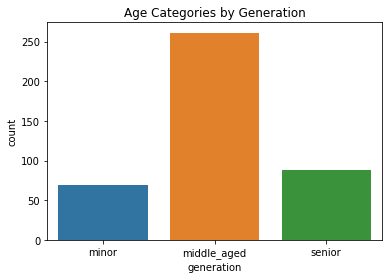

In [23]:
plt.title('Age Categories by Generation')
sns.countplot(x = 'generation', data = train3, order=['minor', 'middle_aged', 'senior'])

#### 2 . Pandas의 cut() 활용하기

이 방법이 위의 Threshold로 하는 방법보다 간결하긴 하지만, 결국 Indicator 변수를 학습에 이용하고자 하는 경우에는 위의 np.where() 방법으로 Indicator Variable 생성과 구간화를 모두 할 수 있는 점이 장점?아닌 장점일 수 있다.

In [24]:
# pd.cut()
# Definiing group labels
cut_labels = ['minor', 'middle_aged', 'senior']

# defining bin edges
cut_bins = [0, 21, 39, 76]

train3['cut_generation'] = pd.cut(train3['Age'], bins=cut_bins, labels=cut_labels)
display(train3.head())

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,CabinNullIndicator,minors,seniors,generation,cut_generation
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,0,Q,0,0,0,middle_aged,middle_aged
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,0,S,0,0,1,senior,senior
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,0,Q,0,0,1,senior,senior
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,0,S,0,0,0,middle_aged,middle_aged
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,0,S,0,0,0,middle_aged,middle_aged


In [25]:
# generation 부분이 숫자값이 아니라면 활용이 어려우므로 0,1,2로 변환
# cut_generation Column의 경우는 test 용도로 만든 성격이 강하므로 Drop
if 'cut_generation' in list(train3.columns):
  train3.drop(['cut_generation'], axis=1, inplace=True)

# 1, 2, 3으로 라벨인코딩 해준 부분은 실제로 연령대는 대소 구분이 가능하다는 점을 반영한 인덱싱이다.
def genToNum(dt):
  if dt == "minor":
    return 1
  if dt == "middle_aged":
    return 2
  if dt == "senior":
    return 3

train3['Age_group'] = train3['generation'].apply(genToNum)

display(train3.head())

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,CabinNullIndicator,minors,seniors,generation,Age_group
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,0,Q,0,0,0,middle_aged,2
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,0,S,0,0,1,senior,3
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,0,Q,0,0,1,senior,3
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,0,S,0,0,0,middle_aged,2
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,0,S,0,0,0,middle_aged,2


### 4 . Scaling

- MinMax Scaling
- Standard Scaling

 데이터를 정규화하여 예측 성능을 높이기 위한 목적으로 활용됨.

In [26]:
train4 = copy.deepcopy(train3)

In [27]:
from sklearn.preprocessing import MinMaxScaler
# from sklearn.preprocessing import StandardScaler

In [28]:
# MinMax Scaling
minmax_scaler = MinMaxScaler()

train4['minmax_scaled_age'] = minmax_scaler.fit_transform(train4['Age'].values.reshape(-1,1))
display(train4.head())

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,CabinNullIndicator,minors,seniors,generation,Age_group,minmax_scaled_age
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,0,Q,0,0,0,middle_aged,2,0.452723
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,0,S,0,0,1,senior,3,0.617566
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,0,Q,0,0,1,senior,3,0.815377
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,0,S,0,0,0,middle_aged,2,0.353818
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,0,S,0,0,0,middle_aged,2,0.287881


### 5 . One-hot encoding

In [29]:
train5 = copy.deepcopy(train4)

In [30]:
# one-hot encoding
train5_embarked = pd.get_dummies(train5['Embarked'])
display(train5_embarked.head())

,C,Q,S
0,0,1,0
1,0,0,1
2,0,1,0
3,0,0,1
4,0,0,1


In [31]:
# train5에 train5_embarked로 one-hot encoding된 DataFrame을 합치기
train = pd.concat([train5, train5_embarked], axis=1)
display(train.head())

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,CabinNullIndicator,minors,seniors,generation,Age_group,minmax_scaled_age,C,Q,S
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,0,Q,0,0,0,middle_aged,2,0.452723,0,1,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,0,S,0,0,1,senior,3,0.617566,0,0,1
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,0,Q,0,0,1,senior,3,0.815377,0,1,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,0,S,0,0,0,middle_aged,2,0.353818,0,0,1
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,0,S,0,0,0,middle_aged,2,0.287881,0,0,1


### 6 . Label encoding

In [32]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

In [33]:
# fit과 fit_transform의 차이
encoded = encoder.fit_transform(train['Sex'])

In [34]:
train['encoded_sex'] = encoded

In [35]:
train.encoded_sex.value_counts()

1    266
0    152
Name: encoded_sex, dtype: int64

In [36]:
# male : 1, female : 0 으로 encoding된 것을 확인
train.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,CabinNullIndicator,minors,seniors,generation,Age_group,minmax_scaled_age,C,Q,S,encoded_sex
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,0,...,0,0,0,middle_aged,2,0.452723,0,1,0,1
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,0,...,0,0,1,senior,3,0.617566,0,0,1,0
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,0,...,0,0,1,senior,3,0.815377,0,1,0,1
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,0,...,0,0,0,middle_aged,2,0.353818,0,0,1,1
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,0,...,0,0,0,middle_aged,2,0.287881,0,0,1,0
